<a href="https://colab.research.google.com/github/vkamole/patient-readmission-model/blob/main/patient-readmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
pip install xgboost


In [20]:
import xgboost as xgb

In [21]:
# Import libraries
import pandas as pd
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [22]:
# Load data
train_df = pd.read_csv("train_df.csv")
X = train_df[["age", "gender", "primary_diagnosis", "num_procedures",
              "days_in_hospital", "comorbidity_score", "discharge_to"]]
y = train_df["readmitted"]

In [23]:
# Preprocessing pipeline
categorical_features = ["gender", "primary_diagnosis", "discharge_to"]
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
    remainder="passthrough"
)

In [24]:
# Model pipeline
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(scale_pos_weight=2, eval_metric="logloss"))
])

In [25]:
# Train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender',
                                                   'primary_diagnosis',
                                                   'discharge_to'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [26]:
# Predict on test data
test_df = pd.read_csv("test_df.csv")
predictions = model.predict_proba(test_df)[:, 1]  # Probability of readmission

In [27]:
# Save predictions
pd.DataFrame({"ID": test_df.index, "readmission_risk": predictions}).to_csv("submission.csv", index=False)

In [28]:
from fastapi import FastAPI, HTTPException
import pandas as pd
import joblib

In [29]:
# Save the trained model
joblib.dump(model, "xgboost_readmission_model.pkl")

['xgboost_readmission_model.pkl']

In [30]:
app = FastAPI()
model = joblib.load("xgboost_readmission_model.pkl")

In [31]:
@app.post("/predict")
async def predict(data: dict):
    try:
        df = pd.DataFrame([data])
        risk_score = model.predict_proba(df)[0, 1]
        return {"readmission_risk": float(risk_score)}
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred = model.predict(X_val)
y_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for AUC

# Display metrics
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       803
           1       0.23      0.13      0.17       197

    accuracy                           0.74      1000
   macro avg       0.52      0.51      0.51      1000
weighted avg       0.69      0.74      0.71      1000

Confusion Matrix:
 [[718  85]
 [171  26]]
ROC AUC Score: 0.48576088399466466


<Figure size 1000x600 with 0 Axes>

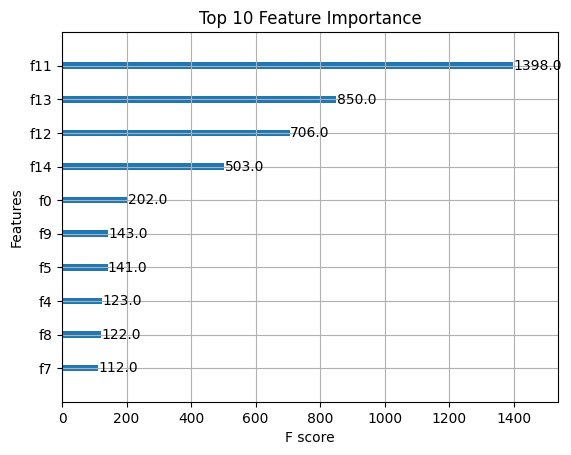

In [34]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Plot top 10 important features
plt.figure(figsize=(10, 6))
plot_importance(model.named_steps['classifier'], max_num_features=10)
plt.title("Top 10 Feature Importance")
plt.show()

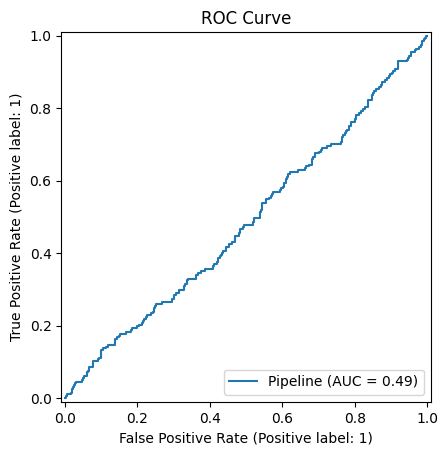

In [35]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(model, X_val, y_val)
plt.title("ROC Curve")
plt.show()

In [36]:
test_df = pd.read_csv("test_df.csv")
test_predictions = model.predict_proba(test_df)[:, 1]  # Readmission probabilities

# Save to CSV
pd.DataFrame({
    "patient_id": test_df.index,
    "readmission_risk": test_predictions
}).to_csv("readmission_predictions.csv", index=False)